In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'experiments/'

### Needed Constants and Variables

In [3]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

In [4]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0)
]

_model_type = {
    (1, 0, 0): 'Delay priority',
    (0, 1, 0): 'Throughput priority',
    (0, 0, 1): 'Flow priority',
    (0.5, 0.5, 0): 'Delay-Throughput priority',
    (0, 0.5, 0.5): 'Throughput-Flow priority',
    (0.5, 0, 0.5): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

cols = [
    'Delay priority',
    'Throughput priority',
    'Flow priority',
    'Delay-Throughput priority',
    'Throughput-Flow priority',
    'Delay-Flow priority',
    'Equal priority',
    'Parent model'
]

In [5]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}


## Loading dataframes

In [6]:
# Results of the MILP solver only (Expected)

df_milp = pd.read_pickle(DF_PATH + 'milp-realtime-results.pkl')

df_milp.head()

,runtime,delay,throughput,objective_value,demand,new_model,alpha,beta,gamma,model_type,epoch
0,165.827293,3069.088608,51.278481,709.539027,450,True,1.00,0.00,0.00,Delay priority,0
5,596.403170,3069.088608,51.278481,-666.881330,450,True,0.50,0.00,0.50,Delay-Flow priority,0
3,539.389628,3069.088608,51.278481,258.865157,450,True,0.50,0.50,0.00,Delay-Throughput priority,0
6,833.726650,3069.088608,51.278481,-503.438553,450,True,0.33,0.33,0.33,Equal priority,0
2,673.527163,3265.265823,52.278481,-2055.801688,450,False,0.00,0.00,1.00,Flow priority,0


In [7]:
# Results of the LocalSim simulator only (Actual)

df_ave_delay = pd.read_pickle(DF_PATH + 'ave_delay.pkl')
df_total_delay = pd.read_pickle(DF_PATH + 'total_delay.pkl')
df_total_thru = pd.read_pickle(DF_PATH + 'total_throughput.pkl')

df_total_thru.head()

level_1,"(1, 0, 0)","(1, 0, 1)","(1, 0, 2)","(1, 0, 3)",demand,new_model,alpha,beta,gamma,model_type
0,1039.0,1051.0,1075.0,957.0,450,True,1.0,0.0,0.0,Delay priority
1,915.0,1126.0,1157.0,1024.0,450,True,0.0,1.0,0.0,Throughput priority
2,1041.0,964.0,1049.0,1087.0,450,True,0.0,0.0,1.0,Flow priority
3,998.0,998.0,1099.0,1071.0,450,True,0.5,0.5,0.0,Delay-Throughput priority
4,1082.0,885.0,1118.0,1027.0,450,True,0.0,0.5,0.5,Throughput-Flow priority


In [8]:
# Comparing computed and measured values (Expected vs Actual)

df_delay_comp = pd.read_pickle(DF_PATH + 'delay_comparison.pkl')
df_thru_comp = pd.read_pickle(DF_PATH + 'throughput_comparison.pkl')

df_delay_comp.head()

,demand,model_type,expected,actual,epoch
95,450,Delay priority,3069.088608,593.394878,0
94,450,Delay priority,7006.430380,5322.015216,1
93,450,Delay priority,8527.316456,8380.821153,2
92,450,Throughput priority,3500.000000,594.768753,0
91,450,Throughput priority,9228.835443,6945.216995,1


## Checking actual delay in the 32 cases

In [9]:
df_total_delay['total_delay_sansleft'] = df_total_delay.iloc[:, 4:24].sum(axis=1)
df_total_delay_table = df_total_delay.pivot(index='demand', columns='model_type', values='total_delay_sansleft')[cols]

df_total_delay_table = df_total_delay_table.apply(lambda x: x / 3600)

print("Total actual delay over 10 minutes (in vehicle-hours)")
df_total_delay_table.round(2)

Total actual delay over 10 minutes (in vehicle-hours)


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,17.03,24.68,23.09,17.19,23.17,22.69,21.61,6.36
900,79.98,78.37,78.47,84.26,82.00,85.16,80.15,33.16
"(450, 900)",45.40,50.88,54.92,48.21,56.35,44.21,46.15,13.98
"(900, 1800)",84.74,89.57,89.16,84.64,88.27,88.72,87.95,44.46


In [10]:
df_delay_percent = (df_total_delay_table.iloc[:, :-1] - df_total_delay_table[['Parent model']].values) * -100 / df_total_delay_table[['Parent model']].values
#df_total_thru_table[['Parent model']]

df_delay_percent#.mean(axis=1).mean()

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,-167.583918,-287.787210,-262.723938,-170.035179,-264.084306,-256.446904,-239.573086
900,-141.176005,-136.302174,-136.611831,-154.087036,-147.271809,-156.802666,-141.673076
"(450, 900)",-224.814937,-264.080397,-292.969638,-244.969591,-303.170738,-216.346881,-230.226747
"(900, 1800)",-90.620994,-101.482974,-100.545027,-90.384785,-98.559158,-99.568118,-97.823180


## Checking actual throughput in the 32 cases

In [11]:
df_total_thru['total_throughput'] = df_total_thru.iloc[:, :4].sum(axis=1)
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='total_throughput')[cols]

print("Total actual throughput over 10 minutes (in vehicles)")
df_total_thru_table

Total actual throughput over 10 minutes (in vehicles)


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,4122.0,4222.0,4141.0,4166.0,4112.0,3991.0,4230.0,3408.0
900,5867.0,5655.0,5729.0,5893.0,5876.0,5942.0,5824.0,6776.0
"(450, 900)",5129.0,5295.0,5114.0,4913.0,5239.0,5120.0,4960.0,4861.0
"(900, 1800)",5896.0,5789.0,5909.0,5784.0,5790.0,5873.0,5969.0,6857.0


## By what percent?

In [12]:
df_thru_percent = (df_total_thru_table.iloc[:, :-1] - df_total_thru_table[['Parent model']].values) * 100 / df_total_thru_table[['Parent model']].values
#df_total_thru_table[['Parent model']]

df_thru_percent.round(2)#.mean(axis=1)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,20.95,23.88,21.51,22.24,20.66,17.11,24.12
900,-13.41,-16.54,-15.45,-13.03,-13.28,-12.31,-14.05
"(450, 900)",5.51,8.93,5.20,1.07,7.78,5.33,2.04
"(900, 1800)",-14.01,-15.58,-13.83,-15.65,-15.56,-14.35,-12.95


## Checking initial computation runtime in the 32 cases

In [13]:
df_milp[df_milp.epoch == 0].pivot(index='demand', columns='model_type', values='runtime')[cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,165.83,307.25,673.53,539.39,306.12,596.40,833.73,0.23
900,5.30,320.72,741.40,8.20,321.44,9.37,10.58,0.21
"(450, 900)",45.76,117.59,171.39,55.88,143.66,55.09,97.73,0.31
"(900, 1800)",2.27,55.22,90.26,2.30,54.26,2.75,2.76,0.18


## Checking recomputation runtime in the 32 cases (average across epochs)

In [14]:
df_milp[df_milp.epoch != 0].pivot_table(index='demand', columns='model_type', values='runtime', aggfunc='mean')[cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,1.63,0.84,0.48,2.11,0.90,1.90,2.08,0.09
900,1.75,0.43,0.38,1.72,0.93,1.54,1.64,0.09
"(450, 900)",1.84,0.97,0.70,1.84,1.07,1.84,2.08,0.10
"(900, 1800)",1.46,0.35,0.36,1.52,1.01,1.69,1.77,0.08


## Checking error of computed and measured delay

In [15]:
df_delay_comp['error'] = df_delay_comp.apply(lambda row: (row.expected - row.actual) * 100 / (row.expected), axis=1)
df_delay_error = df_delay_comp.pivot_table(index='demand', columns='model_type', values='error', aggfunc=np.mean)[cols]

print("Percent error of delay")
print("Note: values for parent model may be inaccurate, due to no left turns being measured")
df_delay_error

Percent error of delay
Note: values for parent model may be inaccurate, due to no left turns being measured


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,35.474793,26.745752,25.386005,32.296497,24.589822,24.931214,22.574063,80.558079
900,-11.567475,-5.423745,-6.764441,-15.071152,-13.537541,-12.334944,-10.853684,49.455939
"(450, 900)",5.695675,5.521533,1.265669,1.636885,-6.093422,9.451102,8.400334,71.738846
"(900, 1800)",1.212913,-4.132165,-3.203967,2.593243,2.256708,-2.832357,0.208173,46.247932


## Checking error of computed and measured throughput

In [16]:
df_thru_comp['error'] = df_thru_comp.apply(lambda row: (row.expected - row.actual) * 100 / (row.expected), axis=1)
df_thru_error = df_thru_comp.pivot_table(index='demand', columns='model_type', values='error', aggfunc=np.mean)[cols]

print("Percent error of throughput")
df_thru_error

Percent error of throughput


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,-387.478751,-397.860558,-401.752267,-410.087811,-386.254402,-387.037052,-418.261385,-275.354349
900,-607.981548,-563.925853,-602.388424,-606.705123,-621.531996,-614.290319,-580.796324,-618.928664
"(450, 900)",-523.808072,-550.238329,-540.620792,-488.162432,-527.381183,-540.161506,-492.917641,-426.465398
"(900, 1800)",-603.009930,-587.235433,-621.956660,-588.447522,-602.272114,-581.699258,-614.729738,-621.824714


## Plot of cumulative delay (lower curve is better)

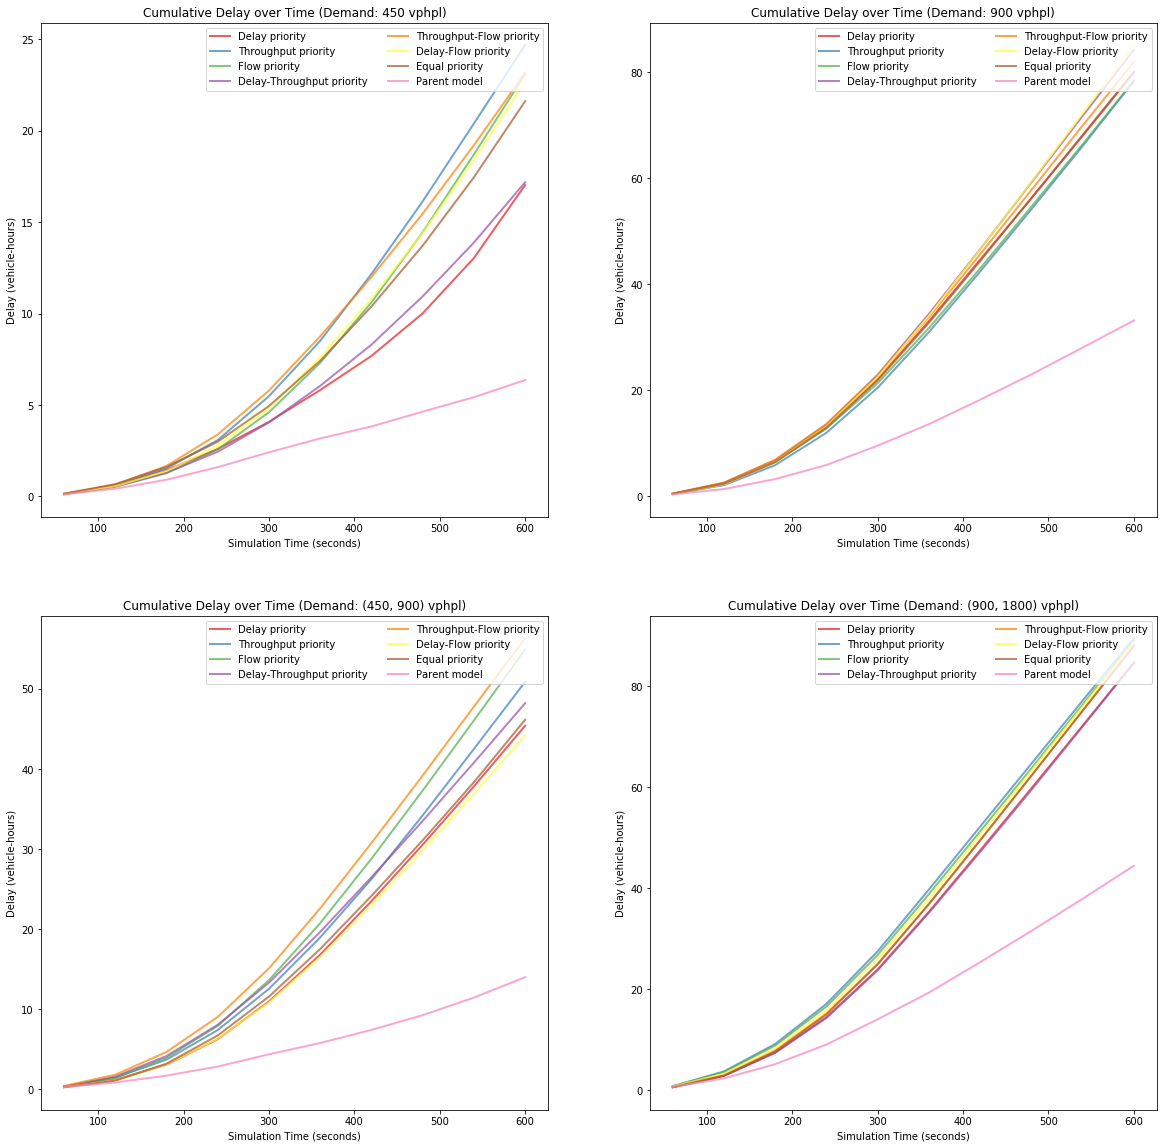

In [17]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumudelays = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-delay/delay_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumudelays[_model_type[weights]] = df_tmp.iloc[:, 4:].sum(axis=1).apply(lambda x: x / 3600)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumudelays:
        axs[ndx / 2, ndx % 2].plot(df_cumudelays.index, df_cumudelays[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Delay over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Delay (vehicle-hours)")

## Plot of cumulative throughput (higher is better)

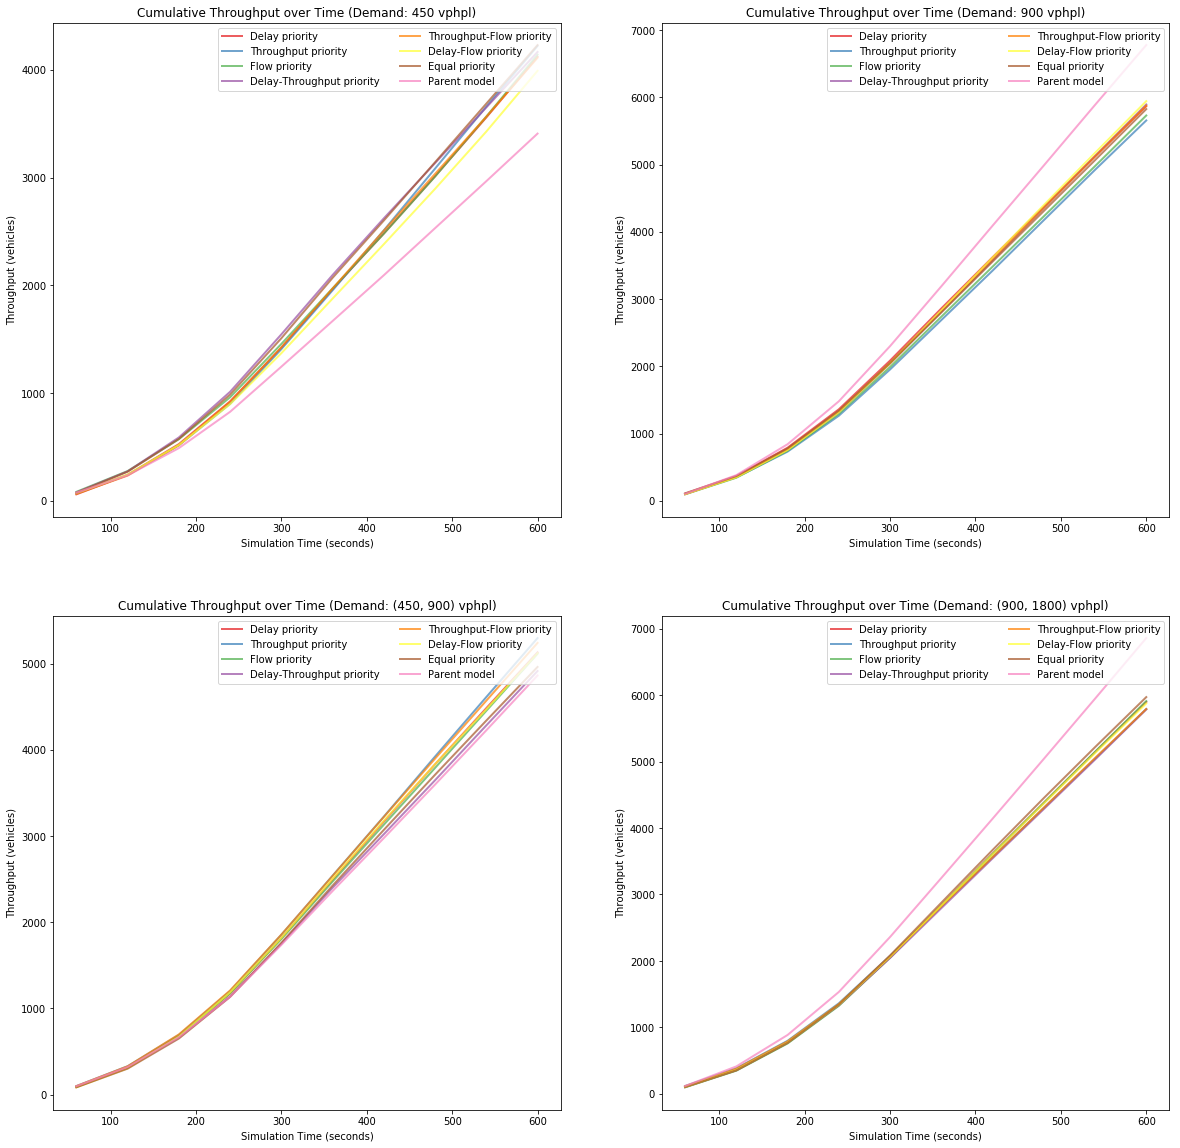

In [18]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumuthrus = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-thru/thru_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumuthrus[_model_type[weights]] = df_tmp.sum(axis=1)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumuthrus:
        axs[ndx / 2, ndx % 2].plot(df_cumuthrus.index, df_cumuthrus[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Throughput over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Throughput (vehicles)")